# MNIST

[http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

## Reading bytes from files

In [1]:
import os.path
import gzip
import numpy as np
import matplotlib.pyplot as plt
import keras as kr
import sklearn.preprocessing as pre

C:\Users\KMora\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Adapted from: https://docs.python.org/3/library/gzip.html


with gzip.open('data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    file_content = f.read()

In [3]:
type(file_content)

bytes

In [4]:
file_content[0:4]

b'\x00\x00\x08\x03'

## Little and big endian

In [5]:
# Adapted from: https://stackoverflow.com/questions/51220161/how-to-convert-from-bytes-to-int

int.from_bytes(file_content[0:4], byteorder='big')

2051

In [6]:
int.from_bytes(file_content[4:8], byteorder='big')

10000

In [7]:
int.from_bytes(file_content[8:12], byteorder='big')

28

In [8]:
int.from_bytes(file_content[12:16], byteorder='big')

28

In [9]:
int.from_bytes(file_content[278:279], byteorder='big')

163

## Reading a single image

In [10]:
l = file_content[16:800]

In [11]:
type(l)

bytes

In [12]:


image = ~np.array(list(file_content[16:800])).reshape(28,28).astype(np.uint8)

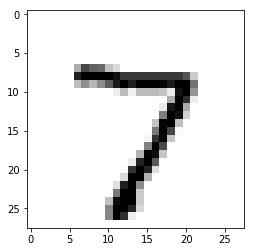

In [13]:
%matplotlib inline


plt.imshow(image, cmap='gray')

## Reading a label

In [14]:
# Adapted from: https://docs.python.org/3/library/gzip.html



with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    labels = f.read()

In [15]:
int.from_bytes(labels[8:9], byteorder="big")

7

## Neural network

In [16]:


from keras.layers import Dense, Dropout, Activation
from keras.models import Model



# Start a neural network, building it by layers.
model = kr.models.Sequential()

# Add a hidden layer with 1000 neurons and an input layer with 784.
model.add(kr.layers.Dense(units=1000, activation='relu', input_dim=784))
model.add(Dropout(0.2)) #Dropout is a technique where randomly selected neurons are ignored during training. 
# They are “dropped-out” randomly. 
# This means that their contribution to the activation of downstream neurons is temporally removed on the 
# forward pass and any weight updates are not applied to the neuron on the backward pass.
model.add(kr.layers.Dense(units=1000, activation='relu'))
model.add(Dropout(0.2))
model.add(kr.layers.Dense(units=1000, activation='relu'))
model.add(Dropout(0.2))
model.add(kr.layers.Dense(units=1000, activation='relu'))


# Add a 10 neuron output layer.
model.add(kr.layers.Dense(units=10, activation='softmax'))

# Build the graph.
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [17]:
with gzip.open('data/train-images-idx3-ubyte.gz', 'rb') as f:
    train_img = f.read()

with gzip.open('data/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_lbl = f.read()
    
train_img = ~np.array(list(train_img[16:])).reshape(60000, 28, 28).astype(np.uint8)
train_lbl =  np.array(list(train_lbl[ 8:])).astype(np.uint8)

In [18]:
inputs = train_img.reshape(60000, 784)/255

In [19]:
# For encoding categorical variables.


encoder = pre.LabelBinarizer()
encoder.fit(train_lbl)
outputs = encoder.transform(train_lbl)

print(train_lbl[0], outputs[0])

5 [0 0 0 0 0 1 0 0 0 0]


In [20]:
model.fit(inputs, outputs, epochs=15, batch_size=100)


Epoch 1/15
60000/60000 [==============================] - 99s 2ms/step - loss: 1.1246 - acc: 0.6486
Epoch 2/15
60000/60000 [==============================] - 91s 2ms/step - loss: 0.4704 - acc: 0.8571
Epoch 3/15
60000/60000 [==============================] - 90s 2ms/step - loss: 0.3797 - acc: 0.8841
Epoch 4/15
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3328 - acc: 0.8994
Epoch 5/15
60000/60000 [==============================] - 89s 1ms/step - loss: 0.2971 - acc: 0.9088
Epoch 6/15
60000/60000 [==============================] - 92s 2ms/step - loss: 0.2686 - acc: 0.9187
Epoch 7/15
60000/60000 [==============================] - 89s 1ms/step - loss: 0.2468 - acc: 0.9254
Epoch 8/15
60000/60000 [==============================] - 88s 1ms/step - loss: 0.2269 - acc: 0.9315
Epoch 9/15
60000/60000 [==============================] - 88s 1ms/step - loss: 0.2096 - acc: 0.9368
Epoch 10/15
60000/60000 [==============================] - 88s 1ms/step - loss: 0.1966 - acc: 0.9409

In [21]:
# save the current model
kr.models.save_model(
    model,
    "savedModel.h5py",
    overwrite=True,
    include_optimizer=True
)

In [22]:
# if the model file exists load it
if os.path.isfile('savedModel.h5py'): 
    model = kr.models.load_model('savedModel.h5py')

In [23]:
with gzip.open('data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    test_img = f.read()

with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    test_lbl = f.read()
    
test_img = ~np.array(list(test_img[16:])).reshape(10000, 784).astype(np.uint8)
test_lbl =  np.array(list(test_lbl[ 8:])).astype(np.uint8)

In [24]:
(encoder.inverse_transform(model.predict(test_img)) == test_lbl).sum()

9637

## End

In [25]:
#model.evaluate(test_img, test_lbl, verbose=0 )
#model.predict(test_img)

score = model.evaluate(test_img, test_lbl, batch_size=100)

ValueError: Error when checking target: expected dense_5 to have shape (10,) but got array with shape (1,)